A notebook for translating the airglow_group.dat from skycorr into something easier to use/read for LVM sky group

In [1]:
from astropy.table import Table
import numpy as np
from astropy.io import fits, ascii
import matplotlib.pyplot as plt

In [2]:
tab=ascii.read('airglow_groups_lvm.dat')

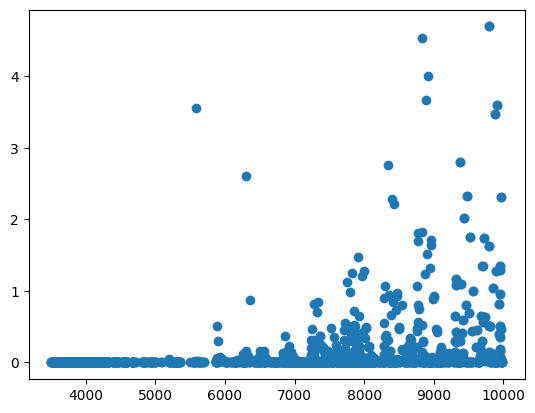

In [3]:
plt.scatter(tab['col1']*1e4,tab['col2'])

In [4]:
#from https://classic.sdss.org/dr7/products/spectra/vacwavelength.php
wave_vac=tab['col1']*1e4
wave = wave_vac / (1.0 + 2.735182E-4 + 131.4182 / wave_vac**2 + 2.76249E8 / wave_vac**4)
#using the formula in Noll+12, but seems to give larger shifts
#wave_nvac=tab['col1']
#nwave = wave_nvac/(1 + 10E-8*(8342.13+2406030.0/(130.0-wave_nvac**-2)+15997/(38.9-wave_nvac**-2)))
#nwave = nwave*1e4

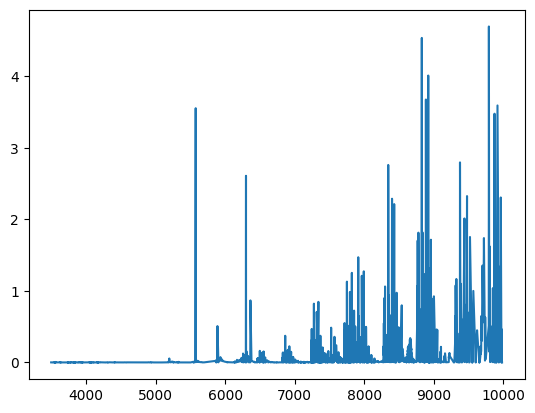

In [5]:
#plotting the line emission at each line
plt.plot(wave,tab['col2'])

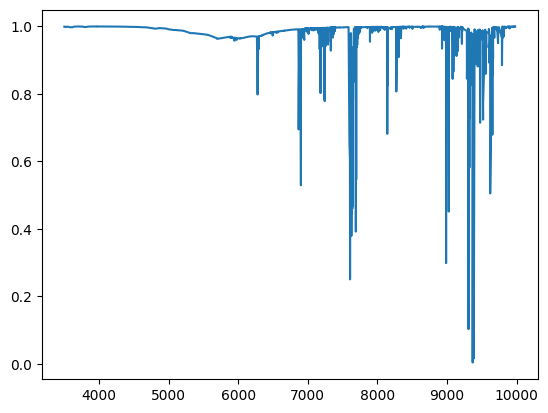

In [6]:
#plotting the transmission at each line
plt.plot(wave,tab['col3'])

(-0.1, 0.5)

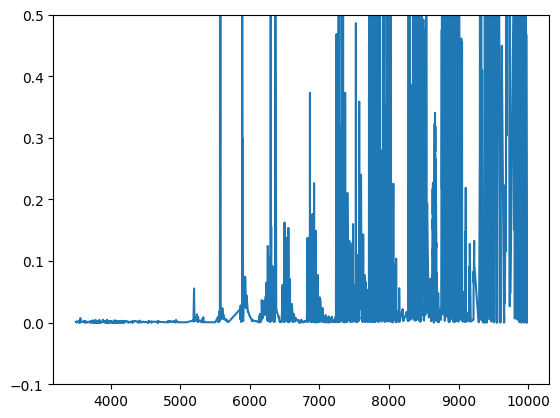

In [7]:
#zooming in to see what would be a reasonable cut on flux, chose 0.05 which has 370 lines
plt.plot(wave, tab['col2'])
plt.ylim(-0.1,0.5)

In [8]:
#mask for just the brighter lines (note flux is still in original units)
bright=tab['col2']>0.05

In [9]:
#opening a local LVM file to get a sky spectrum to compare with
with fits.open('/Users/amjones/repos/lvm_ksl/2024Oct15_v1.1.0/lvmSFrame-00006443.fits') as hdul:
    sky=hdul['SKY'].data
    sky_wave=hdul['WAVE'].data

(7000.0, 9000.0)

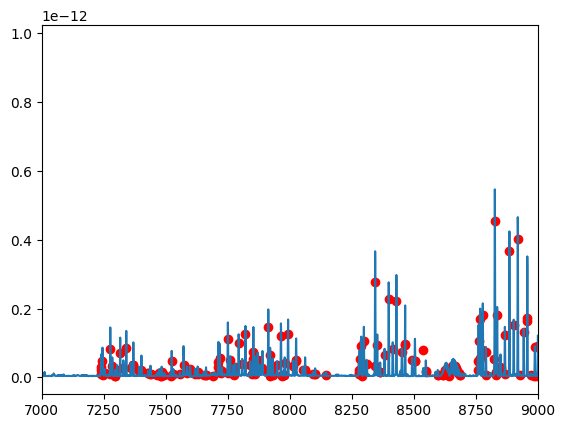

In [10]:
#comparing location and strength of sky lines (scaled) from table with sky lines from LVM spectrum
plt.plot(sky_wave, sky[0])
plt.scatter(wave[bright], tab['col2'][bright]*1e-13, color='red')
plt.xlim(7000, 9000)

(7500.0, 7800.0)

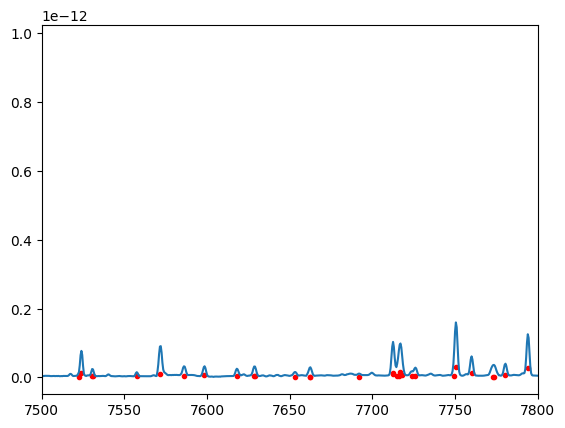

In [11]:
#flux conversion into LVM flux units using Knox's formula (looks too low..)
q=1.98644586e-13*np.pi*(37./2.)**2/wave
flux=tab['col2']*q
plt.plot(sky_wave,sky[0])
plt.scatter(wave[bright],flux[bright], color='red',marker='.')
plt.xlim(7500,7800)

In [21]:
#electronic state and rotational upper levels from Group A and B
e_state=tab['col6']
e_state[tab['col4'] < 4] = -999
rot_up=tab['col7']
rot_up[tab['col4'] < 4] = -999

In [27]:
new_tab=Table()
new_tab['wave [Ang]']=wave[bright]
new_tab['flux [lvm units]']=flux[bright]
new_tab['flux [eso units]']=tab['col2'][bright]
new_tab['trans']=tab['col3'][bright]
new_tab['type']=tab['col4'][bright]
new_tab['electronic_state']=e_state[bright]
new_tab['rotational_upper_level']=rot_up[bright]
new_tab.meta['comments']=['Table is orginally from arglow_groups.dat in the ESO sky model',
                          'unsure about flux conversion so provide both the oringnal fluxes and converted',
                          'type is defined as  Type: 1: OI5577, 2: NaID, 3: OIred, 4: OH, 5: O2 (Noll+2012)',
                          'OH (X-X), O2(b-X) with the electronic states and rotational upper levels in table',
                          'written with make_lvm_skylines_table.ipynb 2025 June 4 (Amy Jones)']

In [28]:
ascii.write(new_tab, 'lvm_sky_lines.dat', overwrite=True, format='fixed_width')